Add Lineup to Model

    - Last time we scraped individual batter data for the 7300+ players who have appeared in a starting lineup between 1970 and 2022.

    - We then processed the data to get statistics about the trailing performance of each of the players before each game in which they started.

    - Using this, we were able to get features related to each player that could be used to predict each game. We then averaged across the lineup in several different ways to come up with a variety of lineup related statistics.
    
    - Now, we will add these features to the model and see how much improvement we get

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
df = pd.read_csv('df_bp9.csv', low_memory=False)

BEGIN MODELING

In [3]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1970) & (df.season<=2015) & ~(df.OBP_162_h.isnull())]
df_valid = df[(df.season>=2016) & (df.season<=2020)]
df_test = df[df.season>=2021]
df_test_val = df[df.season>=2019]

In [4]:
df.shape

(115999, 1235)

In [5]:
hv_mean = df_train.home_victory.mean()
hv_mean

0.5398545529038206

Let's add in some lineup features

In [6]:
target = 'home_victory'

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [7]:
def try_features(feat_set, max_depth=2):
    target = 'home_victory'
    X_train = df_train.loc[:,feat_set]
    X_valid = df_valid.loc[:,feat_set]
    X_test = df_test.loc[:,feat_set]



    lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=max_depth)
    lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50)])
    
    preds_lgbm_test = lgbm1.predict_proba(X_test)[:,1]
    ll_test = log_loss(y_test, preds_lgbm_test)

    print(f'\nVegas probs: {log_loss(y_test,df_test.implied_prob_h_mid)} on test')
    print(f'model probs: {ll_test} on test')

    print(f'\nDifference: {ll_test - log_loss(y_test,df_test.implied_prob_h_mid)} on test')

    sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
    sv_lgbm = pd.DataFrame(sv_lgbm)
    sv_lgbm.columns = list(X_test.columns)+['Intercept']
    sv_vec = sv_lgbm.abs().mean().sort_values(ascending=False)
    print('\nAvg Shap Vals')
    
    print(sv_vec)
    out_dict={}
    out_dict['ll_test'] = ll_test
    out_dict['model'] = lgbm1
    out_dict['shap_val_avgs'] = sv_vec
    out_dict['preds_test'] = preds_lgbm_test
    return(out_dict)

First, let's revisit our best model from our last modeling session

In [8]:
features0 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v']

In [9]:
d0 = try_features(features0)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[775]	valid_0's binary_logloss: 0.676971

Vegas probs: 0.6675629431340582 on test
model probs: 0.671882436698374 on test

Difference: 0.004319493564315824 on test

Avg Shap Vals
Intercept               0.162363
Strt_SO_perc_10_v       0.091345
Strt_SO_perc_10_h       0.083929
Strt_WHIP_35_v          0.067997
Strt_WHIP_35_h          0.059607
OBP_162_h               0.058045
OBP_162_v               0.056137
SLG_162_h               0.047146
SLG_162_v               0.038256
Strt_TB_BB_perc_35_h    0.032208
Strt_H_BB_perc_35_h     0.029595
Bpen_SO_perc_75_v       0.026026
Strt_TB_BB_perc_35_v    0.023442
Bpen_TB_BB_perc_75_h    0.019523
Bpen_H_BB_perc_35_h     0.015074
Bpen_TB_BB_perc_10_v    0.014737
Strt_H_BB_perc_35_v     0.014017
Bpen_H_BB_perc_75_h     0.013301
Bpen_SO_perc_75_h       0.011724
Bpen_SO_perc_10_v       0.011486
Bpen_TB_BB_perc_35_v    0.010371
Bpen_WHIP_75_h          0.009101


In [10]:
f_lineup_a = [
            'lineup9_OBP_162_h','lineup9_OBP_162_v',
            'lineup9_SLG_162_h','lineup9_SLG_162_v',
]

In [11]:
features1 = features0 + f_lineup_a
d1 = try_features(features1)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[839]	valid_0's binary_logloss: 0.676168

Vegas probs: 0.6675629431340582 on test
model probs: 0.6709105819268425 on test

Difference: 0.0033476387927843243 on test

Avg Shap Vals
Intercept               0.162708
Strt_SO_perc_10_v       0.091226
Strt_SO_perc_10_h       0.081569
Strt_WHIP_35_v          0.063550
Strt_WHIP_35_h          0.056239
lineup9_OBP_162_h       0.043667
OBP_162_v               0.041021
lineup9_SLG_162_h       0.040706
lineup9_SLG_162_v       0.038281
OBP_162_h               0.036636
lineup9_OBP_162_v       0.035308
Strt_TB_BB_perc_35_h    0.033518
SLG_162_h               0.028979
Strt_H_BB_perc_35_h     0.025143
Strt_TB_BB_perc_35_v    0.024740
SLG_162_v               0.020019
Bpen_SO_perc_75_v       0.019449
Bpen_TB_BB_perc_75_h    0.018750
Bpen_H_BB_perc_35_h     0.015254
Bpen_TB_BB_perc_10_v    0.015234
Bpen_H_BB_perc_75_h     0.012819
Strt_H_BB_perc_35_v     0.01175

For comparison sake, let's use the individual batters instead

In [12]:
slg_indiv_cols = [x for x in df.columns if '_b' in x and 'SLG_162' in x]
obp_indiv_cols = [x for x in df.columns if '_b' in x and 'OBP_162' in x]

In [13]:
features2 = features0 + slg_indiv_cols + obp_indiv_cols
d2 = try_features(features2, max_depth=2)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[984]	valid_0's binary_logloss: 0.675714

Vegas probs: 0.6675629431340582 on test
model probs: 0.6710834188514149 on test

Difference: 0.003520475717356697 on test

Avg Shap Vals
Intercept               0.162740
Strt_SO_perc_10_v       0.090001
Strt_SO_perc_10_h       0.077874
Strt_WHIP_35_v          0.065818
Strt_WHIP_35_h          0.058371
OBP_162_h               0.040486
OBP_162_v               0.033158
Strt_TB_BB_perc_35_h    0.025036
Strt_H_BB_perc_35_h     0.024234
SLG_162_h               0.022317
SLG_162_b6_h            0.021390
SLG_162_b2_v            0.020917
SLG_162_b9_h            0.019425
Strt_TB_BB_perc_35_v    0.018889
OBP_162_b3_v            0.018714
OBP_162_b5_h            0.018676
Bpen_TB_BB_perc_75_h    0.017422
OBP_162_b7_h            0.016183
OBP_162_b6_v            0.015879
OBP_162_b8_h            0.015778
OBP_162_b4_h            0.015065
Bpen_SO_perc_75_v  

In [14]:
features3 = features0 + slg_indiv_cols + obp_indiv_cols + f_lineup_a
d3 = try_features(features3)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's binary_logloss: 0.675698

Vegas probs: 0.6675629431340582 on test
model probs: 0.6708826442373054 on test

Difference: 0.003319701103247197 on test

Avg Shap Vals
Intercept               0.162874
Strt_SO_perc_10_v       0.091724
Strt_SO_perc_10_h       0.078109
Strt_WHIP_35_v          0.062391
Strt_WHIP_35_h          0.056248
lineup9_OBP_162_h       0.039336
lineup9_SLG_162_h       0.034880
lineup9_SLG_162_v       0.032370
lineup9_OBP_162_v       0.029936
Strt_TB_BB_perc_35_h    0.028867
OBP_162_h               0.026561
OBP_162_v               0.026145
Strt_H_BB_perc_35_h     0.024786
Strt_TB_BB_perc_35_v    0.022617
SLG_162_h               0.021861
Bpen_TB_BB_perc_75_h    0.018237
OBP_162_b3_v            0.016449
Bpen_SO_perc_75_v       0.014430
Bpen_TB_BB_perc_10_v    0.014176
SLG_162_b2_v            0.014149
Bpen_H_BB_perc_75_h     0.013618
OBP_162_b4_h       

In [15]:
f_lineup_b =  [
            'lineup9_OBS_162_h','lineup9_OBS_162_v',
            'lineup9_SLGmod_162_h','lineup9_SLGmod_162_v',
            'lineup9_SObat_perc_162_h','lineup9_SObat_perc_162_v',
]
features4 = features0  +f_lineup_a + f_lineup_b
d4 = try_features(features4)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[668]	valid_0's binary_logloss: 0.676273

Vegas probs: 0.6675629431340582 on test
model probs: 0.6712943609046206 on test

Difference: 0.0037314177705624063 on test

Avg Shap Vals
Intercept                   0.162423
Strt_SO_perc_10_v           0.086342
Strt_SO_perc_10_h           0.074177
Strt_WHIP_35_v              0.061699
Strt_WHIP_35_h              0.053246
OBP_162_h                   0.036926
OBP_162_v                   0.036846
lineup9_OBS_162_h           0.035344
Strt_TB_BB_perc_35_h        0.031245
lineup9_OBP_162_v           0.026474
Strt_H_BB_perc_35_h         0.025822
lineup9_OBP_162_h           0.025514
SLG_162_h                   0.024750
Strt_TB_BB_perc_35_v        0.024423
lineup9_SLG_162_v           0.022606
lineup9_OBS_162_v           0.022594
lineup9_SLGmod_162_h        0.020908
Bpen_TB_BB_perc_75_h        0.019519
SLG_162_v                   0.017423
lineup9_SLG_162_h    

In [16]:
f_lineup_a_w =  [
            'lineup9_OBP_162_w_h','lineup9_OBP_162_w_v',
            'lineup9_SLG_162_w_h','lineup9_SLG_162_w_v',
]
features5 = features0+f_lineup_a_w
d5 = try_features(features5)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[820]	valid_0's binary_logloss: 0.676101

Vegas probs: 0.6675629431340582 on test
model probs: 0.6708200306778161 on test

Difference: 0.003257087543757975 on test

Avg Shap Vals
Intercept               0.162675
Strt_SO_perc_10_v       0.090637
Strt_SO_perc_10_h       0.082382
Strt_WHIP_35_v          0.061427
Strt_WHIP_35_h          0.058814
lineup9_OBP_162_w_h     0.044779
lineup9_SLG_162_w_v     0.042228
OBP_162_v               0.041042
lineup9_SLG_162_w_h     0.037310
OBP_162_h               0.035684
Strt_TB_BB_perc_35_h    0.032749
lineup9_OBP_162_w_v     0.029805
SLG_162_h               0.029434
Strt_TB_BB_perc_35_v    0.024327
Strt_H_BB_perc_35_h     0.022651
Bpen_SO_perc_75_v       0.019912
SLG_162_v               0.018851
Bpen_TB_BB_perc_75_h    0.018233
Bpen_TB_BB_perc_10_v    0.014443
Bpen_H_BB_perc_35_h     0.014250
Bpen_H_BB_perc_75_h     0.013028
Strt_H_BB_perc_35_v     0.012080

In [17]:
f_lineup_a_8 =  [
            'lineup8_OBP_162_w_h','lineup8_OBP_162_w_v',
            'lineup8_SLG_162_w_h','lineup8_SLG_162_w_v',
]
features6 = features0+f_lineup_a_8
d6 = try_features(features6)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[839]	valid_0's binary_logloss: 0.675958

Vegas probs: 0.6675629431340582 on test
model probs: 0.6703670273741288 on test

Difference: 0.0028040842400706145 on test

Avg Shap Vals
Intercept               0.162649
Strt_SO_perc_10_v       0.091660
Strt_SO_perc_10_h       0.081292
Strt_WHIP_35_v          0.065794
Strt_WHIP_35_h          0.057209
lineup8_SLG_162_w_h     0.040208
OBP_162_h               0.040135
lineup8_SLG_162_w_v     0.039247
OBP_162_v               0.038468
lineup8_OBP_162_w_h     0.031329
Strt_TB_BB_perc_35_h    0.031310
SLG_162_h               0.031046
Strt_H_BB_perc_35_h     0.029346
lineup8_OBP_162_w_v     0.025843
Strt_TB_BB_perc_35_v    0.024200
Bpen_SO_perc_75_v       0.021244
SLG_162_v               0.020931
Bpen_TB_BB_perc_75_h    0.019168
Bpen_TB_BB_perc_10_v    0.015273
Bpen_H_BB_perc_35_h     0.014115
Bpen_H_BB_perc_75_h     0.013074
Strt_H_BB_perc_35_v     0.01209

In [18]:
f_lineup_c = [
            'lineup9_OBP_350_h','lineup9_OBP_350_v',
            'lineup9_SLG_350_h','lineup9_SLG_350_v',
]

f_lineup_d = [
            'lineup9_OBP_75_h','lineup9_OBP_75_v',
            'lineup9_SLG_75_h','lineup9_SLG_75_v',
]
features7 = features0 + f_lineup_a + f_lineup_c+ f_lineup_d
d7 = try_features(features7, max_depth=2)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[762]	valid_0's binary_logloss: 0.675846

Vegas probs: 0.6675629431340582 on test
model probs: 0.6711537890624325 on test

Difference: 0.003590845928374331 on test

Avg Shap Vals
Intercept               0.162695
Strt_SO_perc_10_v       0.089661
Strt_SO_perc_10_h       0.078153
Strt_WHIP_35_v          0.062269
Strt_WHIP_35_h          0.051367
lineup9_SLG_350_v       0.037911
OBP_162_h               0.034320
OBP_162_v               0.033279
Strt_TB_BB_perc_35_h    0.031410
lineup9_SLG_350_h       0.030330
Strt_H_BB_perc_35_h     0.027087
SLG_162_h               0.026992
Strt_TB_BB_perc_35_v    0.022719
lineup9_OBP_350_h       0.018553
Bpen_TB_BB_perc_75_h    0.017980
Bpen_SO_perc_75_v       0.016317
lineup9_OBP_162_h       0.016241
lineup9_SLG_75_v        0.015729
SLG_162_v               0.015131
Bpen_H_BB_perc_35_h     0.013801
lineup9_SLG_75_h        0.013640
Bpen_TB_BB_perc_10_v    0.013408

In [19]:
f_simple = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v']
features8 = f_simple

d8 = try_features(features8, max_depth=2)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[352]	valid_0's binary_logloss: 0.685168

Vegas probs: 0.6675629431340582 on test
model probs: 0.6838181979882408 on test

Difference: 0.016255254854182666 on test

Avg Shap Vals
Intercept    0.160869
OBP_162_h    0.079931
OBP_162_v    0.072240
SLG_162_v    0.052395
SLG_162_h    0.049537
dtype: float64


Model Analysis

    - Is there any other evidence that this last enhancement "improved" the model?

    - LV model is still better overall, but are we "adding any value"? Is our model "catching" anything they are not?

In [20]:
discreps_lv0 = (d0['preds_test']-df_test.implied_prob_h_mid).to_numpy() # Without lineup features
discreps_lv1 = (d1['preds_test']-df_test.implied_prob_h_mid).to_numpy() # With lineup features

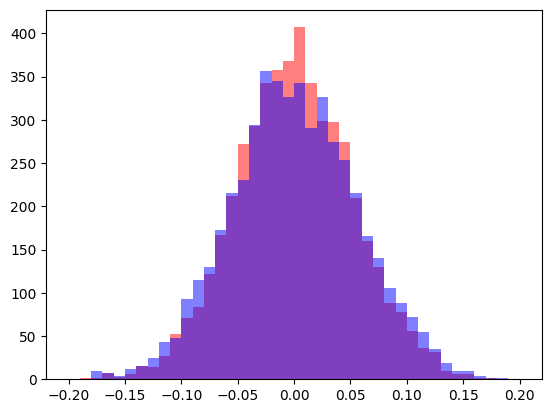

In [21]:
plt.hist(discreps_lv1, bins=np.linspace(-.2,.2,41), alpha=.5, color='red');
plt.hist(discreps_lv0, bins=np.linspace(-.2,.2,41), alpha=.5, color='blue');

Histogram above shows that we are closer to the Las Vegas model after adding in the lineup features

In [22]:
np.mean(np.abs(discreps_lv1)), np.mean(np.abs(discreps_lv0))

(0.041226392476188006, 0.04510140018077673)

Let's look at whether we get better predictions by making a weighted average of our model and the Las Vegas probs

In [23]:
weak_model_preds = d8['preds_test']
strong_model_preds = d1['preds_test']

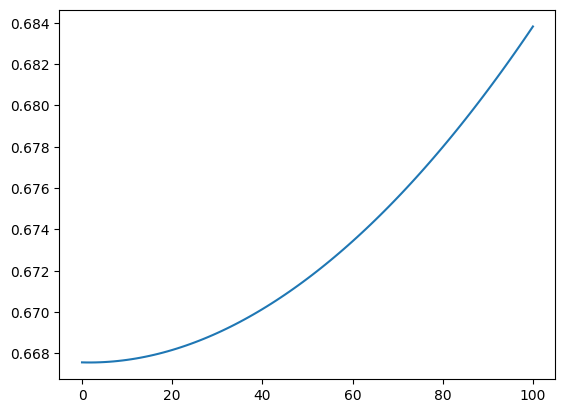

In [24]:
## Mixing in our first (very simple) model
ll_mix_vec_weak = [log_loss(y_test, (k*weak_model_preds+(1-k)*df_test.implied_prob_h_mid)) for k in np.linspace(0,1,101)]
plt.plot(ll_mix_vec_weak)

In [25]:
ll_mix_vec_weak[0] - np.min(ll_mix_vec_weak), np.argmin(ll_mix_vec_weak)

(4.9074286664341216e-06, 2)

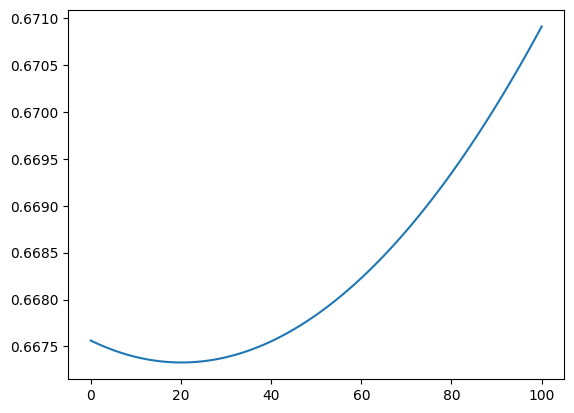

In [26]:
## Mixing in our latest model
ll_mix_vec_strong = [log_loss(y_test, (k*strong_model_preds+(1-k)*df_test.implied_prob_h_mid)) for k in np.linspace(0,1,101)]
plt.plot(ll_mix_vec_strong)

In [27]:
ll_mix_vec_strong[0] - np.min(ll_mix_vec_strong), np.argmin(ll_mix_vec_strong)

(0.00023396985792467628, 20)

In [ ]:
pv_true = df_test.implied_prob_h_mid

In [28]:
# Simulate different model variations on a single test set
# Gives a sense of how much different models (each with the same quality)
# will vary
def ll_model_discrep_shuffle(probvec_true, discreps, num_trials, answers):
    # sim_outcome = np.random.binomial(n=1, p=probvec_true)
    llvec_mod = np.zeros(num_trials)
    discr1 = discreps.copy()
    for i in range(num_trials):
        np.random.shuffle(discr1)
        pv_mod = pv_true  + discr1
        llvec_mod[i] = log_loss(answers, pv_mod)
    return(llvec_mod)

In [29]:
losses = ll_model_discrep_shuffle(pv_true, discreps_lv1, 10000, y_test)

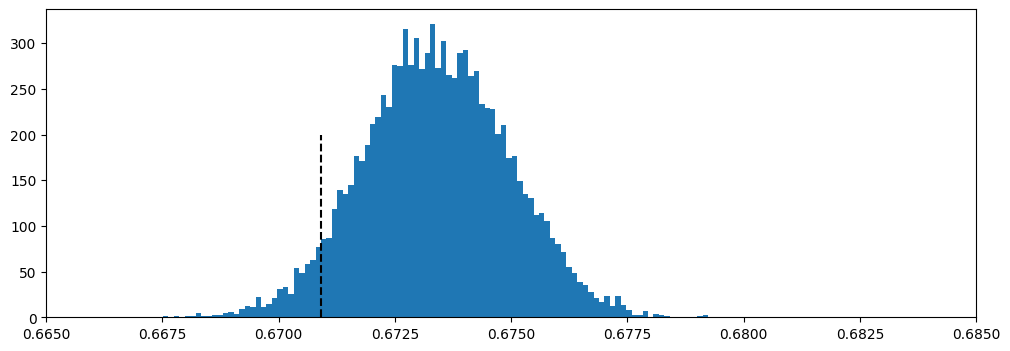

In [30]:
plt.figure(figsize=(12,4))
plt.hist(losses, bins=100);
plt.xlim([.665,.685]);
plt.vlines(x=log_loss(y_test, strong_model_preds), ymin=0, ymax=200, color='k', linestyle='--')

Conclusions

    - We went from ~40bps to ~30bps by adding lineup variables OBS, SLG (for home and away)

    - Changing variants, adding more variables did not seem to improve at all

    - Vegas model is still better overall, but evidence that our model captures effects that they don't

Next Steps

    - Want to model runs scored 
        
        -- will certainly be useful for predicting the over / under
        
        -- may also prove useful for predicting the winner of the game

    - Will want to use probabilistic regression to get a distribution on the runs scored rather than a point estimate